In [1]:
import numpy as np
import xarray as xr
import os, tqdm

import matplotlib.pyplot as plt 
plt.style.use("/mnt/c/Users/johan/OneDrive/Skrivebord/Master_Thesis/setup/matplotlib_style/standard_plot_style.mplstyle")
# plt.rcParams["font.size"] = 10
# plt.rcParams["axes.titlesize"] = "medium"

path = '/mnt/c/Data/Master Thesis/1000_sample_50_mikrosecond_demodulated.nc'
data = xr.open_dataset(path)



In [2]:
def mean_demod(data, start, stop):
    return data.sel(adc_timestamp=slice(start*1e-9, stop*1e-9)).mean(dim='adc_timestamp')

def mean_and_scatter_plot(data, start, stop, ax):
    mean = mean_demod(data, start, stop)
    ax.scatter(mean.I_ground, mean.Q_ground, label='ground')
    ax.scatter(mean.I_excited, mean.Q_excited, label='excited')
    ax.set_xlabel('I')
    ax.set_ylabel('Q')
    ax.set_title(f'{start}ns - {stop}ns')
    ax.legend()

def convert_to_train_set(data, start, stop):
    mean = mean_demod(data, start, stop)
    X =  np.concatenate([np.vstack((mean.I_ground, mean.Q_ground)), np.vstack((mean.I_excited, mean.Q_excited))], axis = 1).T
    y = np.concatenate((np.zeros(mean.I_ground.size), np.ones(mean.I_excited.size)))
    return X, y

In [3]:
from ipywidgets import interactive

def plotter(start, stop):
    fig, ax = plt.subplots()
    mean_and_scatter_plot(data, start, stop, ax)
    plt.show()

interactive_plot = interactive(plotter, start=(0, 50000, 100), stop=(0, 50000, 100))
interactive_plot

interactive(children=(IntSlider(value=25000, description='start', max=50000, step=100), IntSlider(value=25000,…

In [4]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# train_model 
X, y = convert_to_train_set(data, 0, 1000)
lda = LDA()
lda.fit(X, y)

LinearDiscriminantAnalysis()

Text(0.5, 1.0, 'Predicted labels from 0ns to 1000ns')

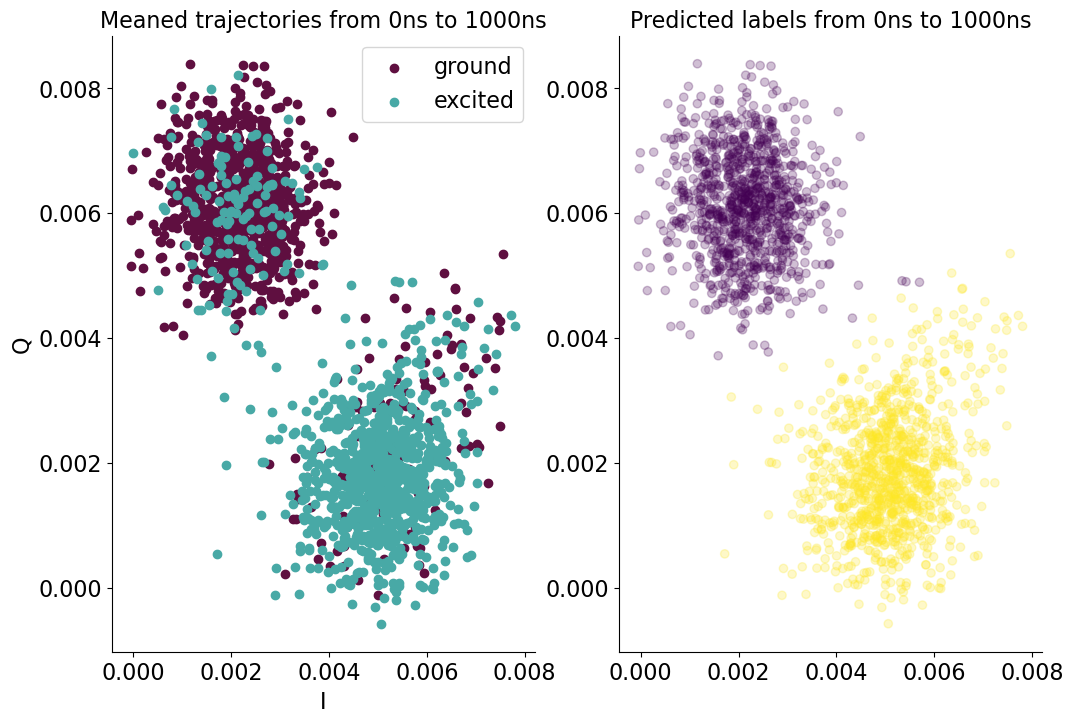

In [5]:
start, stop = 0, 1000
X, y = convert_to_train_set(data, start, stop)

fig, ax = plt.subplots(ncols = 2)
mean_and_scatter_plot(data, start, stop, ax[0])

pred = lda.predict(X)
ax[1].scatter(X[:, 0], X[:, 1], c = pred, alpha = 0.25)

ax[0].set_title(f'Meaned trajectories from {start}ns to {stop}ns', fontsize = 16 )
ax[1].set_title(f'Predicted labels from {start}ns to {stop}ns', fontsize = 16 )


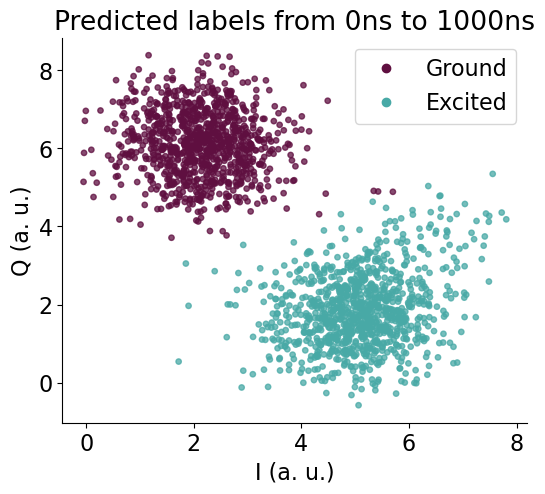

In [6]:
start, stop = 0, 1000
X, y = convert_to_train_set(data, start, stop)

fig, ax = plt.subplots(figsize = (6, 5))
# mean_and_scatter_plot(data, start, stop, ax)

pred = lda.predict(X)
ax.scatter(X[:, 0]*1000, X[:, 1]*1000, c = ["C1" if p == 1 else "C0" for p in pred], alpha = 0.75, s = 15)

ax.plot([], [], "o", color = "C0", label = "Ground")
ax.plot([], [], "o", color = "C1", label = "Excited")

ax.legend()

ax.set(
    xlabel = "I (a. u.)",
    ylabel = "Q (a. u.)",
    title = f"Predicted labels from {start}ns to {stop}ns",
)

fig.savefig("Distributions_long_pulse.pdf", bbox_inches = "tight")

# ax[0].set_title(f'Meaned trajectories from {start}ns to {stop}ns', fontsize = 16 )
# ax[1].set_title(f'Predicted labels from {start}ns to {stop}ns', fontsize = 16 )


In [7]:
counts_ground = {0: [], 1: []}
counts_ground_error = {0: [], 1: []}

for start in tqdm.tqdm(np.arange(0, 50000, 1000)):
    stop = start + 1000
    X, y = convert_to_train_set(data, start, stop)

    pred = lda.predict(X[y == 0])

    counts_ground[0].append(np.sum(pred == 0))
    counts_ground[1].append(np.sum(pred == 1))

    counts_ground_error[0].append(np.sqrt(np.sum(pred == 0) * (pred.size - np.sum(pred == 0))/ pred.size))
    counts_ground_error[1].append(np.sqrt(np.sum(pred == 1) * (pred.size - np.sum(pred == 1))/ pred.size))

counts_excited = {0: [], 1: []}
counts_excited_error = {0: [], 1: []}

for start in tqdm.tqdm(np.arange(0, 50000, 1000)):
    stop = start + 1000
    X, y = convert_to_train_set(data, start, stop)

    pred = lda.predict(X[y == 1])

    counts_excited[0].append(np.sum(pred == 0))
    counts_excited[1].append(np.sum(pred == 1))

    counts_excited_error[0].append(np.sqrt(np.sum(pred == 0) * (pred.size - np.sum(pred == 0))/ pred.size))
    counts_excited_error[1].append(np.sqrt(np.sum(pred == 1) * (pred.size - np.sum(pred == 1))/ pred.size))

    

100%|██████████| 50/50 [00:00<00:00, 200.08it/s]


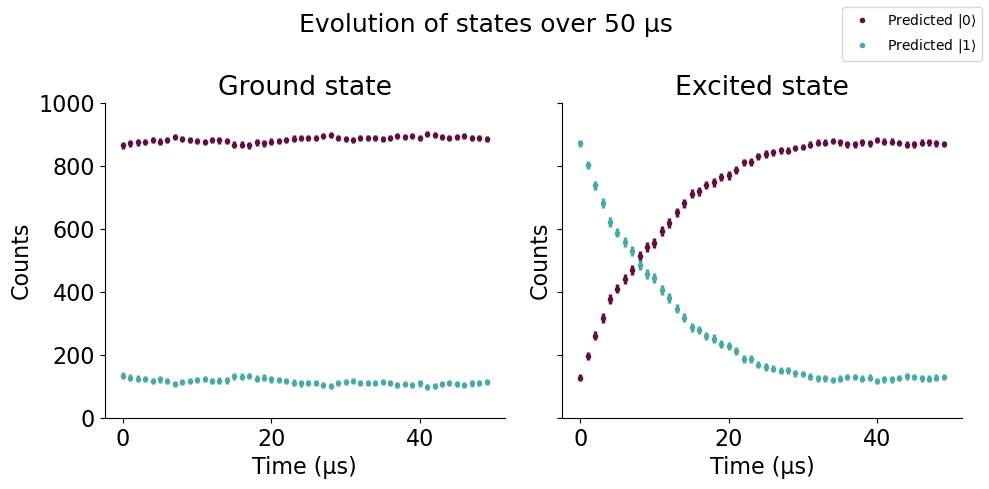

In [8]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5), sharey= True)

ax[0].plot(counts_ground[0], marker = ".", ls = "none", color = "C0")
ax[0].errorbar(np.arange(0, 50, 1), counts_ground[0], yerr = counts_ground_error[0], ls = "none", color = "C0")
ax[0].plot(counts_ground[1], marker = ".", ls = "none", color = "C1")
ax[0].errorbar(np.arange(0, 50, 1), counts_ground[1], yerr = counts_ground_error[1], ls = "none", color = "C1")
# ax[0].plot(np.array(counts_ground[0]) + np.array(counts_ground[1]))




ax[1].plot(counts_excited[0], label = "Predicted $|0\\rangle$", marker = ".", ls = "none", color = "C0")
ax[1].errorbar(np.arange(0, 50, 1), counts_excited[0], yerr = counts_excited_error[0], ls = "none", color = "C0")
ax[1].plot(counts_excited[1], label = "Predicted $|1\\rangle$", marker = ".", ls = "none", color = "C1")
ax[1].errorbar(np.arange(0, 50, 1), counts_excited[1], yerr = counts_excited_error[1], ls = "none", color = "C1")
# ax[1].plot(np.array(counts_excited[0]) + np.array(counts_excited[1]))

fig.suptitle("Evolution of states over 50 µs", fontsize = 18)

ax[0].set_title("Ground state")
ax[1].set_title("Excited state")

ax[0].set(
    xlabel = "Time (µs)",
    ylabel = "Counts",
    ylim = (0, 1000)
)

ax[1].set(
    xlabel = "Time (µs)",
    ylabel = "Counts"
)

fig.legend(loc = "upper right", fontsize = 10)

fig.tight_layout()

In [11]:
# Fitting a model to the data
def ground_func(x, steady_state, offset, decay_time):
    return steady_state + offset * np.exp(-x / decay_time)

def excited_func(x, steady_state, offset, decay_time):
    return steady_state + offset * np.exp(-x / decay_time)

# ground_func = lambda x, steady_state, initial_error, decay_time: steady_state - (
#     steady_state - initial_error
# ) * np.exp(-x / decay_time)

# excited_func = lambda x, steady_state, initial_error, decay_time: steady_state + (
#     1 - steady_state - initial_error
# ) * np.exp(-x / decay_time)

from iminuit import Minuit
from iminuit.cost import LeastSquares

p0_ground = [0.8, 0.1, 1/10]
p0_excited = [0.2, 0.1, 1/10]

cost_ground = LeastSquares(np.arange(50), counts_ground[0], counts_ground_error[0], ground_func)
cost_excited = LeastSquares(np.arange(50), counts_excited[1], counts_excited_error[1], excited_func)

minimizer_ground = Minuit(cost_ground, steady_state = 0.50, offset = 0.50, decay_time = 10)
minimizer_excited = Minuit(cost_excited, steady_state = 0.50, offset = 0.50, decay_time = 10)

minimizer_ground.migrad()
minimizer_excited.migrad()


from scipy.stats import chi2
title = "ground_state"

pval = chi2.sf(minimizer_ground.fval, len(counts_ground[0]) - len(minimizer_ground.values.to_dict()))

with open(f"../{title}.txt", "w") as f:
    print(
        f"chi-squared: {minimizer_ground.fval:.2f} for {len(counts_ground[0]) - len(minimizer_ground.values.to_dict())} dof with p-value {pval:.3f}",
        file=f,
    )
    for name in minimizer_ground.values.to_dict():
        print(
            f"{name} = {minimizer_ground.values[name]:.5e} +- {minimizer_ground.errors[name]:.5e}",
            file=f,
        )

title = "excited_state"

pval = chi2.sf(minimizer_excited.fval, len(counts_excited[1]) - len(minimizer_excited.values.to_dict()))

with open(f"../{title}.txt", "w") as f:
    print(
        f"chi-squared: {minimizer_excited.fval:.2f} for {len(counts_excited[1]) - len(minimizer_excited.values.to_dict())} dof with p-value {pval:.3f}",
        file=f,
    )
    for name in minimizer_excited.values.to_dict():
        print(
            f"{name} = {minimizer_excited.values[name]:.5e} +- {minimizer_excited.errors[name]:.5e}",
            file=f,
        )

# popt_ground, pcov_ground = curve_fit(
#     ground_func, np.arange(0, 50, 1), np.array(counts_ground[0]) / 1000, p0 = p0_ground
# )

# popt_excited, pcov_excited = curve_fit(
#     excited_func, np.arange(0, 50, 1), np.array(counts_excited[1]) / 1000, p0 = p0_excited
# )



RuntimeError: initial_error is not one of the parameters [steady_state offset decay_time]

In [58]:
len(counts_ground) - len(minimizer_ground.values.to_dict())

-1

In [59]:
# Print the results and errors
print("Ground state")
print(f"Steady state: {minimizer_ground.values[0]:.3f} +/- {minimizer_ground.errors[0]:.3f}")
print(f"Initial error: {minimizer_ground.values[1]:.3f} +/- {minimizer_ground.errors[1]:.3f}")
print(f"Decay rate: {minimizer_ground.values[2]:.3f} +/- {minimizer_ground.errors[2]:.3f}")

print("\nExcited state")
print(f"Steady state: {minimizer_excited.values[0]:.3f} +/- {minimizer_excited.errors[0]:.3f}")
print(f"Initial error: {minimizer_excited.values[1]:.3f} +/- {minimizer_excited.errors[1]:.3f}")
print(f"Decay rate: {minimizer_excited.values[2]:.3f} +/- {minimizer_excited.errors[2]:.3f}")



# print(f"Steady state: {popt_excited[0]:.3f} +/- {np.sqrt(pcov_excited[0, 0]):.3f}")
# print(f"Initial error: {popt_excited[1]:.3f} +/- {np.sqrt(pcov_excited[1, 1]):.3f}")
# print(f"Decay rate: {popt_excited[2]:.3f} +/- {np.sqrt(pcov_excited[2, 2]):.3f}")


Ground state
Steady state: 935.013 +/- 161.621
Initial error: 875.143 +/- 3.718
Decay rate: 120.234 +/- 394.611

Excited state
Steady state: 101.789 +/- 3.246
Initial error: -877.383 +/- 7.121
Decay rate: 10.773 +/- 0.222


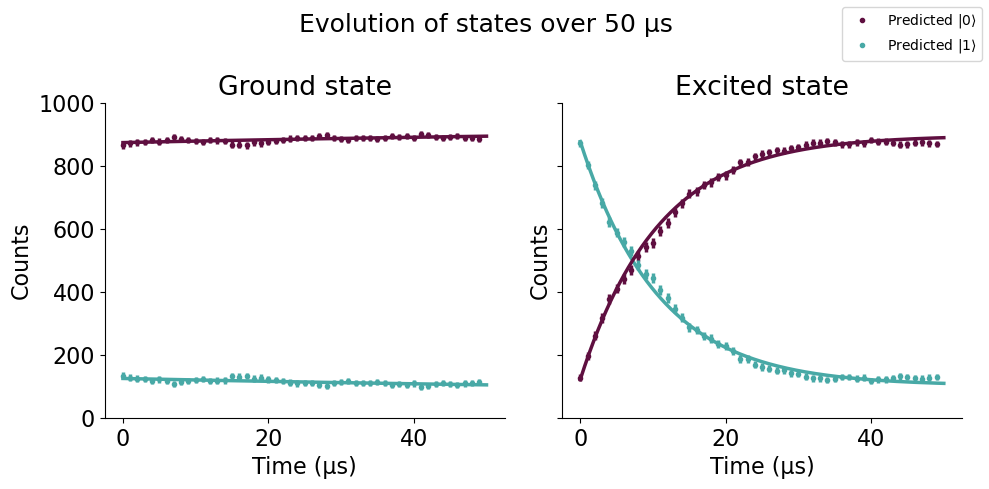

In [10]:
ax[0].plot(np.linspace(0, 50, 1000), ground_func(np.linspace(0, 50, 1000), *minimizer_ground.values), label = "Fit", color = "C0", ls = "-")
ax[0].plot(np.linspace(0, 50, 1000), (1000 - ground_func(np.linspace(0, 50, 1000), *minimizer_ground.values)), label = "1 - Fit", color = "C1", ls = "-")

ax[1].plot(np.linspace(0, 50, 1000), excited_func(np.linspace(0, 50, 1000), *minimizer_excited.values), label = "Fit", color = "C1", ls = "-")
ax[1].plot(np.linspace(0, 50, 1000), (1000 - excited_func(np.linspace(0, 50, 1000), *minimizer_excited.values)), label = "1 - Fit", color = "C0", ls = "-")

# ax[0].legend()
# ax[1].legend()
fig.savefig("Fitting_long_pulse.pdf", bbox_inches = "tight")
fig

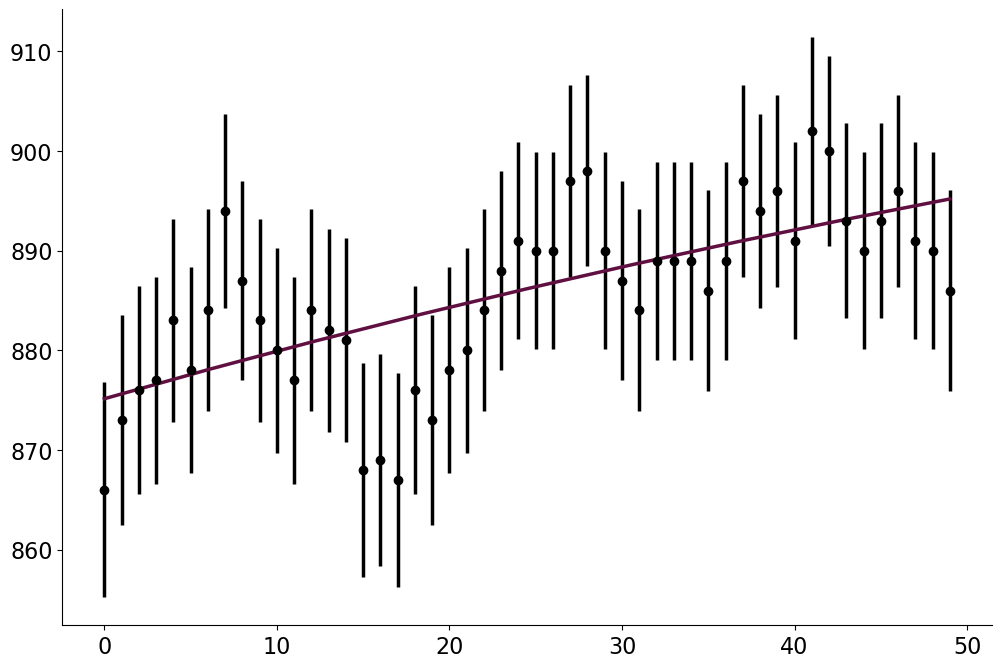

In [61]:
minimizer_ground.visualize()

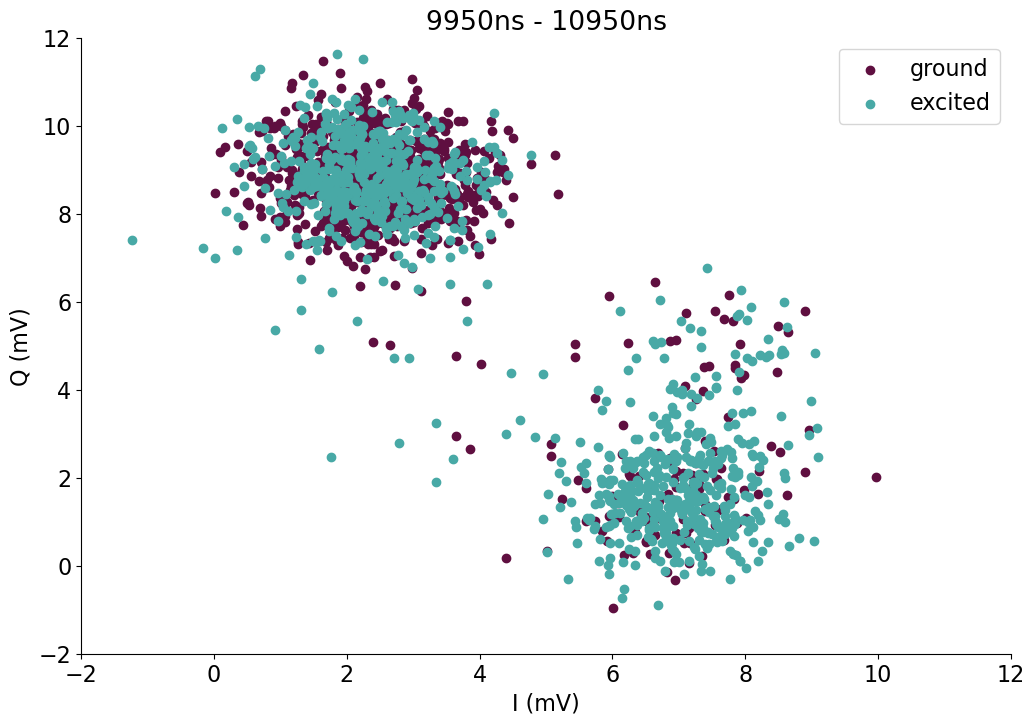

In [62]:
# Create animation of the IQ plane over the time
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()



def animate(i):
    ax.clear()
    start = i
    stop = start + 1000
    mean_and_scatter_plot(data * 1000, start, stop, ax)
    
    ax.set(
        xlim = (-2, 12),
        ylim = (-2, 12),
        title = f'{start}ns - {stop}ns',
        xlabel = 'I (mV)',
        ylabel = 'Q (mV)'
    )

anim = FuncAnimation(fig, animate, frames = np.arange(0, 10000, 50), interval = 50)

from IPython.display import HTML
HTML(anim.to_html5_video())

In [63]:
anim.to

AttributeError: 'FuncAnimation' object has no attribute 'to'

In [ ]:
counts_ground = {0: [], 1: []}

for start in tqdm.tqdm(np.arange(0, 50000, 1000)):
    stop = start + 1000
    X, y = convert_to_train_set(data, start, stop)

    pred = lda.predict(X[y == 0])

    counts_ground[0].append(np.sum(pred == 0))
    counts_ground[1].append(np.sum(pred == 1))

counts_excited = {0: [], 1: []}

for start in tqdm.tqdm(np.arange(0, 50000, 1000)):
    stop = start + 1000
    X, y = convert_to_train_set(data, start, stop)

    pred = lda.predict(X[y == 1])

    counts_excited[0].append(np.sum(pred == 0))
    counts_excited[1].append(np.sum(pred == 1))
    